# Predict driver/non-driver based on Mutational Signature Distribution 
- Logistic regression 
- Decision tree 
- k-NN
- SVMs 
- Random Forest 
- ANNs 



In [1]:
import numpy as np
import pandas as pd

#add libraries and graph settings
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# np.random.seed(24)


In [2]:
## Read file
df_allsamp = pd.read_csv("samples_UCEC_sig_labels.csv")
df_allsamp

,Hugo_Symbol,Tumor_Sample_Barcode,HGVSp,HGVSp_Short,MSI,label,COSMICv3-SBS1,COSMICv3-SBS10a,COSMICv3-SBS10b,COSMICv3-SBS11,...,COSMICv3-SBS7d,COSMICv3-SBS8,COSMICv3-SBS84,COSMICv3-SBS85,COSMICv3-SBS9,ExpPOLEDriverLabel,ExpPOLD1DriverLabel,PredPOLEDriverLabel,PredPOLD1DriverLabel,POLEDriverMSIStatus
0,EPHA2,TCGA-2E-A9G8-01A-11D-A403-09,p.Gly620Arg,G620R,MSS,Passenger,0.116184,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No mutation,No mutation,No mutation,No mutation,D0M0
1,ZNF436,TCGA-2E-A9G8-01A-11D-A403-09,p.Ser202PhefsTer23,S202Ffs*23,MSS,NaN,0.116184,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No mutation,No mutation,No mutation,No mutation,D0M0
2,MECR,TCGA-2E-A9G8-01A-11D-A403-09,p.Leu307His,L307H,MSS,Potential driver,0.116184,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No mutation,No mutation,No mutation,No mutation,D0M0
3,USP24,TCGA-2E-A9G8-01A-11D-A403-09,p.Val908Ala,V908A,MSS,Passenger,0.116184,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No mutation,No mutation,No mutation,No mutation,D0M0
4,IL23R,TCGA-2E-A9G8-01A-11D-A403-09,p.Trp265Ter,W265*,MSS,Passenger,0.116184,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No mutation,No mutation,No mutation,No mutation,D0M0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501078,MAP7D3,TCGA-SL-A6JA-01A-11D-A31U-09,p.Gln191Lys,Q191K,MSI-H,Potential driver,0.141195,0.006316,NaN,NaN,...,NaN,NaN,0.005468,NaN,NaN,No mutation,No mutation,No mutation,No mutation,D0M2
501079,MAGEC1,TCGA-SL-A6JA-01A-11D-A31U-09,p.Glu572ArgfsTer58,E572Rfs*58,MSI-H,NaN,0.141195,0.006316,NaN,NaN,...,NaN,NaN,0.005468,NaN,NaN,No mutation,No mutation,No mutation,No mutation,D0M2
501080,PNCK,TCGA-SL-A6JA-01A-11D-A31U-09,p.Phe212SerfsTer14,F212Sfs*14,MSI-H,NaN,0.141195,0.006316,NaN,NaN,...,NaN,NaN,0.005468,NaN,NaN,No mutation,No mutation,No mutation,No mutation,D0M2
501081,FLNA,TCGA-SL-A6JA-01A-11D-A31U-09,p.Val1830Met,V1830M,MSI-H,Passenger,0.141195,0.006316,NaN,NaN,...,NaN,NaN,0.005468,NaN,NaN,No mutation,No mutation,No mutation,No mutation,D0M2


## 1. Data Preparation

In [3]:
filter_col = ["Tumor_Sample_Barcode", "Hugo_Symbol"] + [col for col in df_allsamp if col.startswith('COSMICv3')] + ["POLEDriverMSIStatus"] ###change targeted classes
df = df_allsamp[filter_col]

In [4]:
# Treat Nan as 0 
sig_cols = [col for col in df_allsamp if col.startswith('COSMICv3')]
df[sig_cols] = df[sig_cols].fillna(0)

/Users/jessysong/miniforge3/envs/env_mutagene/lib/python3.10/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
df['POLEDriverMSIStatus'].unique()

array(['D0M0', 'D2M2', 'D2M1', 'D0M1', 'D0M2', 'D1M2', 'D2M0', 'D1M0',
       nan, 'D1M1'], dtype=object)

In [6]:
# Combine MSS and MSI-L 
df['POLEDriverMSIStatus'].replace(['D0M0', 'D0M1', 'D0M3', 'D1M0', 'D1M1', 'D1M3', 'D2M0', 'D2M1', 'D2M3'], ['D0ML', 'D0ML', 'D0ML', 'D1ML', 'D1ML', 'D1ML', 'D2ML', 'D2ML', 'D2ML'], inplace=True)

/Users/jessysong/miniforge3/envs/env_mutagene/lib/python3.10/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [7]:
df['POLEDriverMSIStatus'].unique()

array(['D0ML', 'D2M2', 'D2ML', 'D0M2', 'D1M2', 'D1ML', nan], dtype=object)

In [24]:
df[df['POLEDriverMSIStatus'].isnull()].Tumor_Sample_Barcode.unique()

#### samples with missing MSI / driver+MSI status. 

array(['TCGA-B5-A0JN-01A-11D-A10B-09', 'TCGA-B5-A0JY-01A-11D-A10B-09',
       'TCGA-B5-A0KB-01B-11D-A14G-09', 'TCGA-B5-A11X-01A-11D-A10M-09',
       'TCGA-PG-A914-01A-11D-A37N-09'], dtype=object)

In [27]:
# Exclude samples with missing MSI status 
df = df[df['POLEDriverMSIStatus'].isnull()==False]

In [29]:
# replacing categorical driver/nondriver to numerical (representing each output cluster)
# df['PredPOLEDriverLabel'].replace(['No mutation', 'Passenger', 'Potential Driver', 'Driver'], [0, 1, 2, 3], inplace=True)
df['POLEDriverMSIStatus'].unique()

array(['D0ML', 'D2M2', 'D2ML', 'D0M2', 'D1M2', 'D1ML'], dtype=object)

In [35]:
# df_POLE = df[df['Hugo_Symbol']=="POLE"].reset_index(drop=True)
# df_POLE = df_POLE[df_POLE['ExpPOLEDriverLabel'] != "No mutation"]
#### investigate if the labelling has something wrong? or take these 2 out first to get a sample going 

Pairwise combined Driver status and MSI status
- D = ['No mutation', 'Non driver', 'Driver'] = [0, 1, 2]
- M = ['MSS', 'MSI-L', 'MSI-H'] = [0, 1, 2] (0 and 1 combined to form ML)


In [30]:
df['POLEDriverMSIStatus'].replace(['D0ML', 'D0M2', 'D1ML', 'D1M2', 'D2ML', 'D2M2'], [0,1,2,3,4,5], inplace=True)

/Users/jessysong/miniforge3/envs/env_mutagene/lib/python3.10/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [31]:
df

,Tumor_Sample_Barcode,Hugo_Symbol,COSMICv3-SBS1,COSMICv3-SBS10a,COSMICv3-SBS10b,COSMICv3-SBS11,COSMICv3-SBS12,COSMICv3-SBS13,COSMICv3-SBS14,COSMICv3-SBS15,...,COSMICv3-SBS60,COSMICv3-SBS7a,COSMICv3-SBS7b,COSMICv3-SBS7c,COSMICv3-SBS7d,COSMICv3-SBS8,COSMICv3-SBS84,COSMICv3-SBS85,COSMICv3-SBS9,POLEDriverMSIStatus
0,TCGA-2E-A9G8-01A-11D-A403-09,EPHA2,0.116184,0.000000,0.0,0.0,0.03632,0.008932,0.0,0.000000,...,0.0,0.020479,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
1,TCGA-2E-A9G8-01A-11D-A403-09,ZNF436,0.116184,0.000000,0.0,0.0,0.03632,0.008932,0.0,0.000000,...,0.0,0.020479,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
2,TCGA-2E-A9G8-01A-11D-A403-09,MECR,0.116184,0.000000,0.0,0.0,0.03632,0.008932,0.0,0.000000,...,0.0,0.020479,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
3,TCGA-2E-A9G8-01A-11D-A403-09,USP24,0.116184,0.000000,0.0,0.0,0.03632,0.008932,0.0,0.000000,...,0.0,0.020479,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
4,TCGA-2E-A9G8-01A-11D-A403-09,IL23R,0.116184,0.000000,0.0,0.0,0.03632,0.008932,0.0,0.000000,...,0.0,0.020479,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501078,TCGA-SL-A6JA-01A-11D-A31U-09,MAP7D3,0.141195,0.006316,0.0,0.0,0.00000,0.000000,0.0,0.079427,...,0.0,0.009693,0.0,0.0,0.0,0.0,0.005468,0.0,0.0,1
501079,TCGA-SL-A6JA-01A-11D-A31U-09,MAGEC1,0.141195,0.006316,0.0,0.0,0.00000,0.000000,0.0,0.079427,...,0.0,0.009693,0.0,0.0,0.0,0.0,0.005468,0.0,0.0,1
501080,TCGA-SL-A6JA-01A-11D-A31U-09,PNCK,0.141195,0.006316,0.0,0.0,0.00000,0.000000,0.0,0.079427,...,0.0,0.009693,0.0,0.0,0.0,0.0,0.005468,0.0,0.0,1
501081,TCGA-SL-A6JA-01A-11D-A31U-09,FLNA,0.141195,0.006316,0.0,0.0,0.00000,0.000000,0.0,0.079427,...,0.0,0.009693,0.0,0.0,0.0,0.0,0.005468,0.0,0.0,1


In [44]:
# Exclude samples with POLD1 mutation 
samp_POLD1 = df[df['Hugo_Symbol']=='POLD1']["Tumor_Sample_Barcode"].unique()
samp_POLD1

array(['TCGA-A5-A0G2-01A-11W-A062-09', 'TCGA-A5-A0VP-01A-21D-A10B-09',
       'TCGA-AJ-A3EK-01A-11D-A19Y-09', 'TCGA-AJ-A3OJ-01A-11D-A228-09',
       'TCGA-AP-A059-01A-21D-A122-09', 'TCGA-AP-A05H-01A-11W-A027-09',
       'TCGA-AP-A1DH-01A-31D-A135-09', 'TCGA-AP-A1DK-01A-11D-A135-09',
       'TCGA-AX-A1C4-01A-11D-A135-09', 'TCGA-AX-A1CE-01A-11D-A135-09',
       'TCGA-AX-A2HD-01A-21D-A17D-09', 'TCGA-AX-A2HJ-01A-11D-A17D-09',
       'TCGA-AX-A3FT-01A-11D-A228-09', 'TCGA-B5-A11H-01A-11D-A122-09',
       'TCGA-B5-A1MX-01A-11D-A142-09', 'TCGA-B5-A3FC-01A-11D-A228-09',
       'TCGA-BG-A0MQ-01A-11D-A10B-09', 'TCGA-BG-A222-01A-11D-A159-09',
       'TCGA-BS-A0TJ-01A-11D-A10B-09', 'TCGA-D1-A15X-01A-11D-A122-09',
       'TCGA-D1-A160-01A-11D-A122-09', 'TCGA-D1-A17D-01A-12D-A12J-09',
       'TCGA-D1-A17M-01A-21D-A12J-09', 'TCGA-D1-A17R-01A-11D-A12J-09',
       'TCGA-D1-A1NS-01A-11D-A14G-09', 'TCGA-DF-A2KN-01A-11D-A17W-09',
       'TCGA-DF-A2KU-01A-11D-A17W-09', 'TCGA-EC-A1NJ-01A-31D-A14G-09',
      

In [60]:
df_POLD1 = df["Tumor_Sample_Barcode"].isin(samp_POLD1)
df = df[~df_POLD1]

In [88]:
# Drop duplicates 
df = df.drop_duplicates("Tumor_Sample_Barcode")

## ++ Feature Selection
- Filter based: We specify some metric and based on that filter features. An example of such a metric could be correlation/chi-square.
- Wrapper-based: Wrapper methods consider the selection of a set of features as a search problem. Example: Recursive Feature Elimination
- Embedded: Embedded methods use algorithms that have built-in feature selection methods. For instance, Lasso and RF have their own feature selection methods.

https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [90]:
# select most important features 
sig_cols = [col for col in df_allsamp if col.startswith('COSMICv3')]
df_sigs = df[sig_cols+["POLEDriverMSIStatus"]]

In [91]:
X = df_sigs[sig_cols]
y = df_sigs['POLEDriverMSIStatus']

### 1. Univariate Selection

In [92]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

              Specs      Score
1   COSMICv3-SBS10a  88.102396
2   COSMICv3-SBS10b  81.889228
57    COSMICv3-SBS6  72.942478
14   COSMICv3-SBS20  27.794867
6    COSMICv3-SBS14  21.846580
0     COSMICv3-SBS1  10.584685
22   COSMICv3-SBS28  10.156220
7    COSMICv3-SBS15  10.127409
51   COSMICv3-SBS54   9.307639
5    COSMICv3-SBS13   7.148497


In [93]:
selected_features_1 = featureScores.nlargest(10,'Score').Specs.to_numpy()

In [94]:
selected_features_1

array(['COSMICv3-SBS10a', 'COSMICv3-SBS10b', 'COSMICv3-SBS6',
       'COSMICv3-SBS20', 'COSMICv3-SBS14', 'COSMICv3-SBS1',
       'COSMICv3-SBS28', 'COSMICv3-SBS15', 'COSMICv3-SBS54',
       'COSMICv3-SBS13'], dtype=object)

### 2. Select from Models

- Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable. Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

[0.04085835 0.07811248 0.0641502  0.00638824 0.0010926  0.01953557
 0.03059712 0.02372092 0.0200947  0.00924381 0.01512995 0.0036331
 0.01084751 0.01955232 0.14210554 0.01206809 0.01153987 0.00688184
 0.01038866 0.00579554 0.00867207 0.00308236 0.02599487 0.00357517
 0.00100851 0.00712015 0.00486512 0.00375665 0.00745204 0.0042936
 0.00520894 0.00309953 0.00189779 0.00299139 0.00456477 0.00135861
 0.00037493 0.00133922 0.00505069 0.00499589 0.00907476 0.00665076
 0.00709174 0.00074815 0.01358634 0.01349957 0.         0.01201634
 0.00353778 0.00530446 0.00710871 0.05524917 0.01132351 0.0064012
 0.00486559 0.00387263 0.01069179 0.13782737 0.00200754 0.01742151
 0.0103668  0.00511891 0.00731641 0.0017014  0.00915249 0.00137736
 0.00424904]


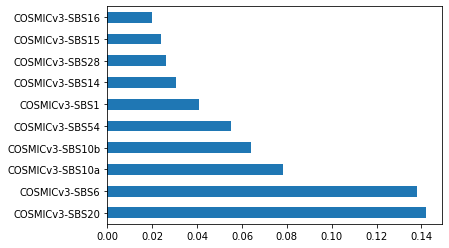

In [95]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [96]:
selected_features_2 = feat_importances.nlargest(10).index.to_numpy()

In [97]:
selected_features_2

array(['COSMICv3-SBS20', 'COSMICv3-SBS6', 'COSMICv3-SBS10a',
       'COSMICv3-SBS10b', 'COSMICv3-SBS54', 'COSMICv3-SBS1',
       'COSMICv3-SBS14', 'COSMICv3-SBS28', 'COSMICv3-SBS15',
       'COSMICv3-SBS16'], dtype=object)

Just for ExpPOLEDriverStatus: 
['COSMICv3-SBS10a', 'COSMICv3-SBS10b', 'COSMICv3-SBS20',
       'COSMICv3-SBS15', 'COSMICv3-SBS14', 'COSMICv3-SBS54',
       'COSMICv3-SBS6', 'COSMICv3-SBS1', 'COSMICv3-SBS49',
       'COSMICv3-SBS17a']

### 3. By correlation matrix

In [102]:
#get correlations of each features in dataset
corrmat = df_sigs.corr()
corr_features = corrmat.index

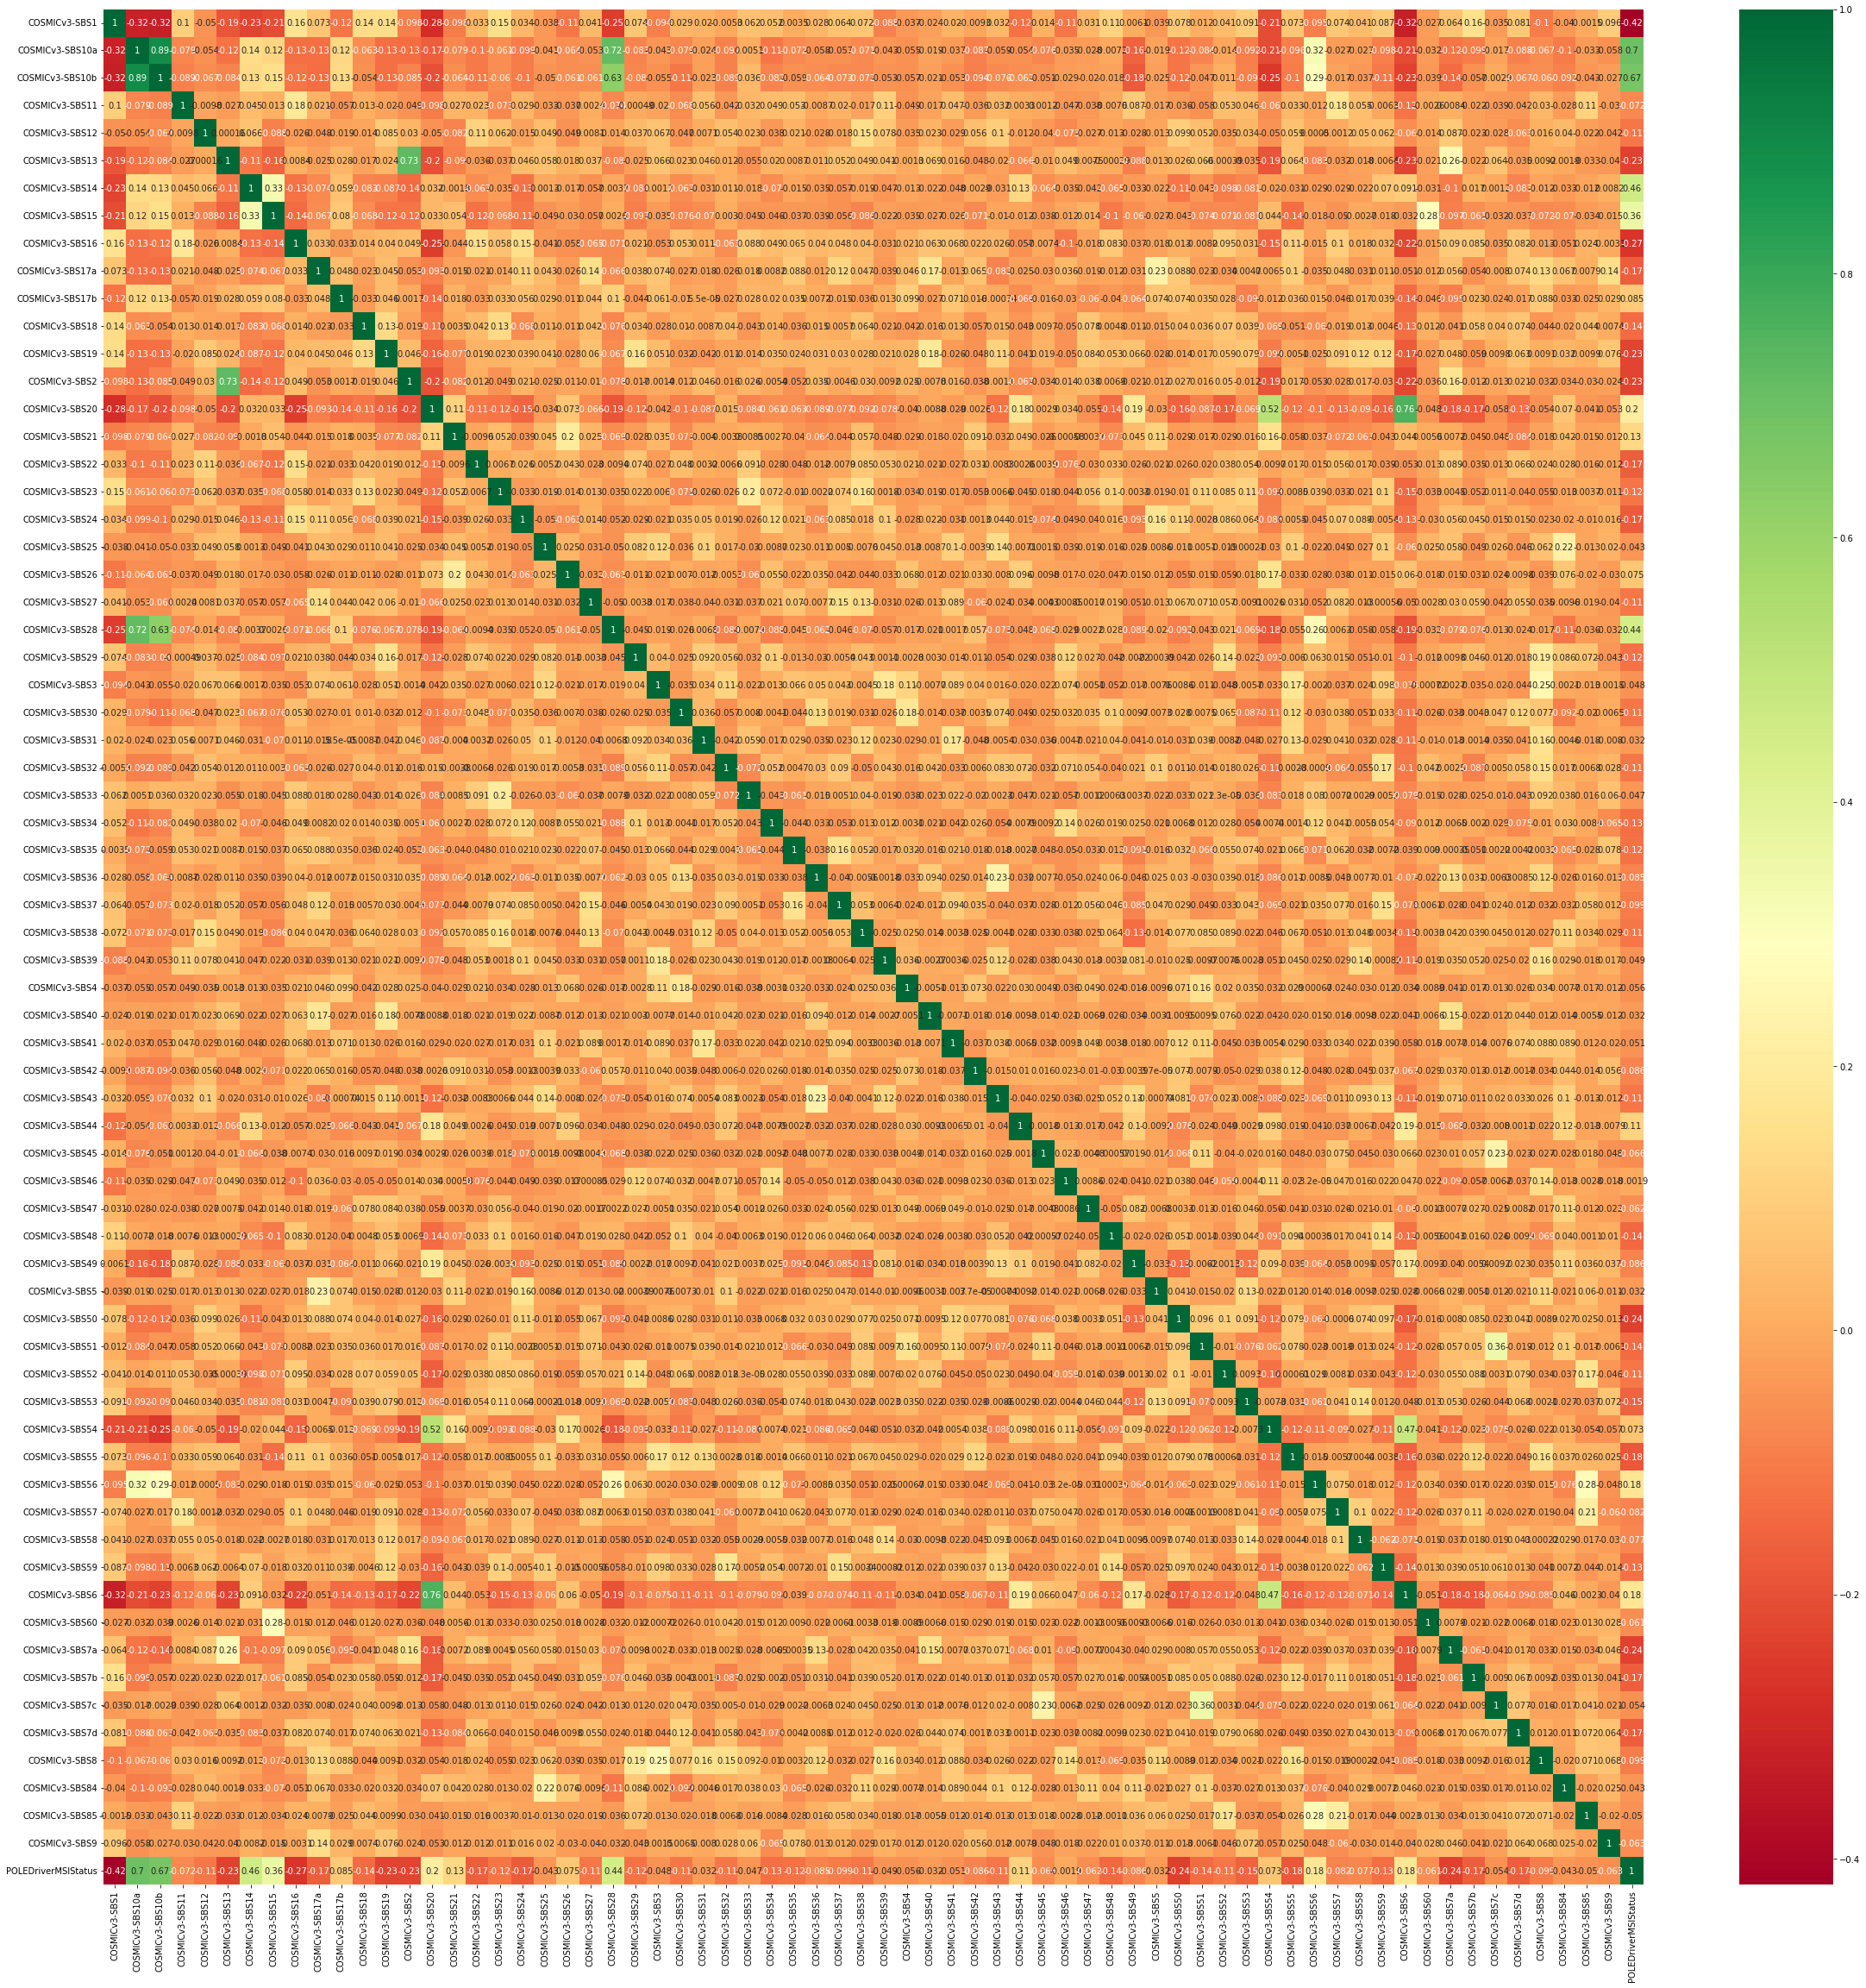

In [103]:
#plot heat map
plt.figure(figsize=(40,40))
g=sns.heatmap(df_sigs[corr_features].corr(),annot=True,cmap="RdYlGn")

In [104]:
selected_features_3 = corrmat['POLEDriverMSIStatus'].abs().nlargest(11).index.drop('POLEDriverMSIStatus').to_numpy()

In [105]:
selected_features_3

array(['COSMICv3-SBS10a', 'COSMICv3-SBS10b', 'COSMICv3-SBS14',
       'COSMICv3-SBS28', 'COSMICv3-SBS1', 'COSMICv3-SBS15',
       'COSMICv3-SBS16', 'COSMICv3-SBS50', 'COSMICv3-SBS7a',
       'COSMICv3-SBS13'], dtype=object)

In [106]:
# Get same features across all 3 methods 
common_features = np.intersect1d(selected_features_1, selected_features_2)
common_features = np.intersect1d(common_features, selected_features_3)
common_features

array(['COSMICv3-SBS1', 'COSMICv3-SBS10a', 'COSMICv3-SBS10b',
       'COSMICv3-SBS14', 'COSMICv3-SBS15', 'COSMICv3-SBS28'], dtype=object)

In [121]:
# Use only the selected features as input
df_selected_sigs = df[common_features.tolist()+["POLEDriverMSIStatus"]]